In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import osmnx as ox


import matplotlib.pylab as plt
%matplotlib inline




## Datarensning


In [ ]:
# This will handle loading and cleaning the Excel data for brukare and medarbetare.
def load_data(file_path):
    """
    Load Excel data and return a dictionary of dataframes.
    """
    # Load the Excel file from the given file path
    excel_data = pd.ExcelFile(file_path)
    
    # Parse the sheets into separate dataframes
    data = {
        'brukare': excel_data.parse('Individer, brukare', header=1),
        'medarbetare': excel_data.parse('Medarbetare', header=2)
    }

    return data


def clean_data(brukare_df, medarbetare_df):
    """
    Clean and structure brukare and medarbetare data for analysis.
    """
    # Rename 'Unnamed: 0' to 'Individ' for brukare_df
    brukare_df.rename(columns={'Unnamed: 0': 'Individ'}, inplace=True)

    # Rename 'Unnamed: 0' to 'Medarbetare' for medarbetare_df
    medarbetare_df.rename(columns={'Unnamed: 0': 'Medarbetare'}, inplace=True)

    # Remove brukare with missing or invalid 'Individ' or 'Adress'
    brukare_df = brukare_df.dropna(subset=['Individ', 'Adress']).copy()
    brukare_df = brukare_df[brukare_df['Individ'] != '-']  # Remove rows where 'Individ' is '-'
    brukare_df = brukare_df[brukare_df['Adress'] != '-']  # Remove rows where 'Adress' is '-'
    
    # Fill missing values in other columns with placeholder '-'
    brukare_df.fillna('-', inplace=True)
    medarbetare_df.fillna('-', inplace=True)

    # Convert relevant columns to boolean
    #brukare_df['Kräver körkort'] = brukare_df['Kräver körkort'].apply(lambda x: x == 'Ja')
    #medarbetare_df['Körkort'] = medarbetare_df['Körkort'].apply(lambda x: x == 'Ja')

    columns_medarbetare = list(medarbetare_df)

    brukare_df['Kräver körkort'] = brukare_df['Kräver körkort'].apply(lambda x: x == 'Ja')
    brukare_df['Behöver insulin'] = brukare_df['Behöver insulin'].apply(lambda x: x == 'Ja')
    brukare_df['Röker'] = brukare_df['Röker'].apply(lambda x: x == 'Ja')
    brukare_df['Har hund'] = brukare_df['Har hund'].apply(lambda x: x == 'Ja')
    brukare_df['Har katt'] = brukare_df['Har katt'].apply(lambda x: x == 'Ja')
    brukare_df['Kräver >18'] = brukare_df['Kräver >18'].apply(lambda x: x == 'Ja')



    for column in columns_medarbetare[1:]:
        medarbetare_df[column] = medarbetare_df[column].apply(lambda x: x == 'Ja')


    return brukare_df, medarbetare_df


data = load_data("Studentuppgift fiktiv planering.xlsx")

brukare_df, medarbetare_df = clean_data(data["brukare"], data["medarbetare"])

display(brukare_df)
display(medarbetare_df)

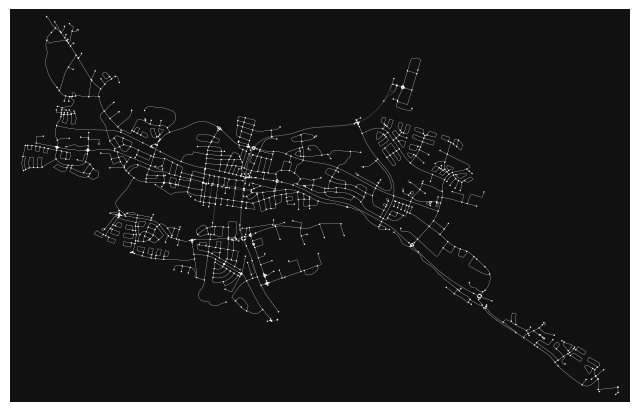

In [8]:
# Define the place name for Skellefteå Kommun
place_name = "Skellefteå, Västerbotten, Sweden"

# Download the road network for driving
G = ox.graph_from_place(place_name, network_type='drive')

# Plot the road network of Skellefteå
fig, ax = ox.plot_graph(G, node_size=1, edge_color='white', edge_linewidth=0.1)
plt.show()



C:\Users\alexa\AppData\Local\Temp\ipykernel_2644\829911068.py:11: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
C:\Users\alexa\AppData\Local\Temp\ipykernel_2644\829911068.py:11: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


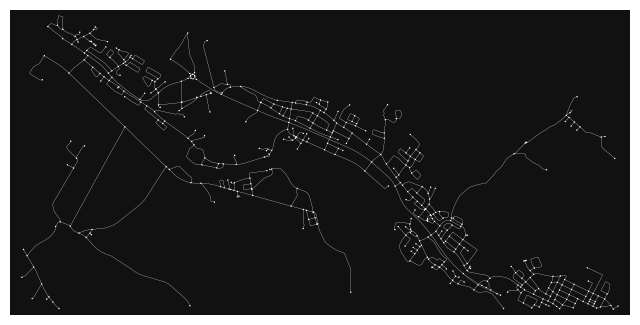

In [12]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the bounding box coordinates (lat/lon)
north = 64.73  # Northernmost latitude
south = 64.69  # Southernmost latitude
east = 21.27   # Easternmost longitude
west = 21.05   # Westernmost longitude

# Download the road network within the bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Plot the graph to visualize the area
fig, ax = ox.plot_graph(G, node_size=1, edge_color='white', edge_linewidth=0.1)
plt.show()
